## Data Loading and Initial Setup
This section loads the cleaned COVID-19 deaths dataset and prepares the environment for data mining analysis.

In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

In [3]:
df = pd.read_csv("covid_deaths_cleaned.csv")
df.head()

date date_announced date_positive date_dose1 date_dose2 date_dose3 brand1 brand2 brand3    state  age  male  \
0  2020-03-17     2020-03-17    2020-03-12        NaN        NaN        NaN    NaN    NaN    NaN    Johor   34     1   
1  2020-03-17     2020-03-17    2020-03-15        NaN        NaN        NaN    NaN    NaN    NaN  Sarawak   60     1   
2  2020-03-20     2020-03-20    2020-03-11        NaN        NaN        NaN    NaN    NaN    NaN    Sabah   58     1   
3  2020-03-21     2020-03-21    2020-03-13        NaN        NaN        NaN    NaN    NaN    NaN   Melaka   50     1   
4  2020-03-22     2020-03-22    2020-03-20        NaN        NaN        NaN    NaN    NaN    NaN  Sarawak   80     0   

   bid  malaysian  comorb  gap_positive_to_death  gap_death_to_announced    vax_status age_group last_dose_date  \
0    0          1       1                      5                       0  Unvaccinated     30-39            NaN   
1    0          1       1                      2                       0  Unvaccinated     60-69            NaN   
2    0          1       1                      9                       0  Unvaccinated     50-59            NaN   
3    0          1       1                      8                       0  Unvaccinated     50-59            NaN   
4    1          1       1                      2                       0  Unvaccinated       70+            NaN   

   days_last_dose_to_death primary_brand  
0                      NaN           NaN  
1                      NaN           NaN  
2                      NaN           NaN  
3                      NaN           NaN  
4                      NaN           NaN

In [4]:
print("Shape:", df.shape)
df.info()

Shape: (37331, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37331 entries, 0 to 37330
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     37331 non-null  object 
 1   date_announced           37331 non-null  object 
 2   date_positive            37331 non-null  object 
 3   date_dose1               14874 non-null  object 
 4   date_dose2               9275 non-null   object 
 5   date_dose3               1543 non-null   object 
 6   brand1                   14874 non-null  object 
 7   brand2                   9275 non-null   object 
 8   brand3                   1543 non-null   object 
 9   state                    37331 non-null  object 
 10  age                      37331 non-null  int64  
 11  male                     37331 non-null  int64  
 12  bid                      37331 non-null  int64  
 13  malaysian                37331 non-null  int64  
 14  com

In [5]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

date_dose3                 35788
brand3                     35788
date_dose2                 28056
brand2                     28056
primary_brand              22457
days_last_dose_to_death    22457
date_dose1                 22457
brand1                     22457
last_dose_date             22457
dtype: int64

In [6]:
df["bid"].value_counts()

bid
0    29398
1     7933
Name: count, dtype: int64

## Feature Selection and Risk Definition
In this study, patient risk is defined using the brought-in-dead (BID) indicator. BID = 1 represents high-risk cases, while BID = 0 represents lower-risk cases. Relevant demographic, clinical, and vaccination-related features are selected for model training.

In [7]:
# Target variable
y = df["bid"].copy()

# Feature columns
feature_cols = [
    "age",
    "male",
    "malaysian",
    "comorb",
    "gap_positive_to_death",
    "days_last_dose_to_death",
    "vax_status",
    "age_group",
    "state"
]

# Create an explicit copy for modelling
X = df[feature_cols].copy()

X.head()

age  male  malaysian  comorb  gap_positive_to_death  days_last_dose_to_death    vax_status age_group    state
0   34     1          1       1                      5                      NaN  Unvaccinated     30-39    Johor
1   60     1          1       1                      2                      NaN  Unvaccinated     60-69  Sarawak
2   58     1          1       1                      9                      NaN  Unvaccinated     50-59    Sabah
3   50     1          1       1                      8                      NaN  Unvaccinated     50-59   Melaka
4   80     0          1       1                      2                      NaN  Unvaccinated       70+  Sarawak

## Data Preprocessing
Missing values were handled using domain knowledge. Vaccination-related missing values indicate unvaccinated cases and were encoded accordingly. Categorical variables were transformed using one-hot encoding to prepare the data for machine learning models.

In [8]:
# Numeric and categorical columns
num_cols = [
    "age",
    "male",
    "malaysian",
    "comorb",
    "gap_positive_to_death",
    "days_last_dose_to_death"
]

cat_cols = [
    "vax_status",
    "age_group",
    "state"
]

# Fill numeric NaNs
X["days_last_dose_to_death"] = X["days_last_dose_to_death"].fillna(-1)

for col in num_cols:
    if col != "days_last_dose_to_death":
        X[col] = X[col].fillna(X[col].median())

# Fill categorical NaNs
for col in cat_cols:
    X[col] = X[col].fillna("Unknown")

# Confirm no missing values
X.isna().sum()


age                        0
male                       0
malaysian                  0
comorb                     0
gap_positive_to_death      0
days_last_dose_to_death    0
vax_status                 0
age_group                  0
state                      0
dtype: int64

In [9]:
X_encoded = pd.get_dummies(
    X,
    columns=["vax_status", "age_group", "state"],
    drop_first=True
)

print("Encoded shape:", X_encoded.shape)
X_encoded.head()

Encoded shape: (37331, 30)


age  male  malaysian  comorb  gap_positive_to_death  days_last_dose_to_death  \
0   34     1          1       1                      5                     -1.0   
1   60     1          1       1                      2                     -1.0   
2   58     1          1       1                      9                     -1.0   
3   50     1          1       1                      8                     -1.0   
4   80     0          1       1                      2                     -1.0   

   vax_status_Fully vaccinated (2 doses)  vax_status_Partial (1 dose)  vax_status_Unvaccinated  age_group_18-29  \
0                                  False                        False                     True            False   
1                                  False                        False                     True            False   
2                                  False                        False                     True            False   
3                                  False                        False                     True            False   
4                                  False                        False                     True            False   

   age_group_30-39  age_group_40-49  age_group_50-59  age_group_60-69  age_group_70+  state_Kedah  state_Kelantan  \
0             True            False            False            False          False        False           False   
1            False            False            False             True          False        False           False   
2            False            False             True            False          False        False           False   
3            False            False             True            False          False        False           False   
4            False            False            False            False           True        False           False   

   state_Melaka  state_Negeri Sembilan  state_Pahang  state_Perak  state_Perlis  state_Pulau Pinang  state_Sabah  \
0         False                  False         False        False         False               False        False   
1         False                  False         False        False         False               False        False   
2         False                  False         False        False         False               False         True   
3          True                  False         False        False         False               False        False   
4         False                  False         False        False         False               False        False   

   state_Sarawak  state_Selangor  state_Terengganu  state_W.P. Kuala Lumpur  state_W.P. Labuan  state_W.P. Putrajaya  
0          False           False             False                    False              False                 False  
1           True           False             False                    False              False                 False  
2          False           False             False                    False              False                 False  
3          False           False             False                    False              False                 False  
4           True           False             False                    False              False                 False

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (29864, 30)
Test shape: (7467, 30)


## Classification Using Logistic Regression
Logistic Regression was applied to classify patients into high-risk and lower-risk groups. The model was chosen for its interpretability and suitability for risk profiling tasks.

In [11]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_reg.fit(X_train, y_train)

print("Logistic Regression trained successfully")

Logistic Regression trained successfully


C:\Users\User\anaconda3\envs\cds6314\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Model Evaluation and Performance Metrics
The classification model was evaluated using accuracy, precision, recall, F1-score, and confusion matrix, with emphasis on recall for high-risk patients.

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on test set
y_pred = log_reg.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed metrics
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

Accuracy: 0.7440739252711932

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      5880
           1       0.44      0.75      0.56      1587

    accuracy                           0.74      7467
   macro avg       0.68      0.75      0.69      7467
weighted avg       0.82      0.74      0.76      7467



array([[4364, 1516],
       [ 395, 1192]], dtype=int64)

## Feature Importance Analysis
This section examines the contribution of each feature to the classification of high-risk patients.

In [13]:
# Extract feature importance from Logistic Regression
feature_importance = pd.DataFrame({
    "feature": X_encoded.columns,
    "coefficient": log_reg.coef_[0]
})

# Absolute value for ranking importance
feature_importance["abs_coefficient"] = feature_importance["coefficient"].abs()

# Sort by importance
feature_importance = feature_importance.sort_values(
    by="abs_coefficient",
    ascending=False
)

# Show top 15 most important features
feature_importance.head(15)

feature  coefficient  abs_coefficient
23                  state_Sabah     1.261949         1.261949
14                age_group_70+    -1.074070         1.074070
13              age_group_60-69    -1.025895         1.025895
2                     malaysian    -1.023727         1.023727
28            state_W.P. Labuan     0.945510         0.945510
3                        comorb    -0.782855         0.782855
16               state_Kelantan     0.750061         0.750061
7   vax_status_Partial (1 dose)    -0.728726         0.728726
12              age_group_50-59    -0.721857         0.721857
15                  state_Kedah     0.527090         0.527090
24                state_Sarawak     0.525402         0.525402
22           state_Pulau Pinang     0.495575         0.495575
8       vax_status_Unvaccinated    -0.479519         0.479519
25               state_Selangor     0.444902         0.444902
17                 state_Melaka     0.434385         0.434385

## Classification Using Decision Tree
A Decision Tree classifier was applied as a comparison model to further analyze risk classification. Decision Trees provide an interpretable structure that helps explain how different attributes contribute to high-risk and lower-risk outcomes.

In [14]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)

dt.fit(X_train, y_train)

print("Decision Tree trained successfully")

Decision Tree trained successfully


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on test set
y_pred_dt = dt.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

# Detailed metrics
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt

Accuracy: 0.7869291549484398

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      5880
           1       0.50      0.78      0.61      1587

    accuracy                           0.79      7467
   macro avg       0.71      0.79      0.73      7467
weighted avg       0.84      0.79      0.80      7467



array([[4635, 1245],
       [ 346, 1241]], dtype=int64)

## Clustering Analysis for Patient Profiling
Clustering was applied to identify distinct patient profiles based on demographic, clinical, and vaccination-related attributes. This unsupervised approach helps reveal underlying patterns without relying on predefined risk labels.

## Clustering Preparation (Data Scaling and Feature Selection)
To perform clustering, numerical features are scaled so that variables with larger ranges do not dominate the distance calculations. Categorical variables are encoded into numeric form, and only clustering-relevant features are selected.

In [16]:
from sklearn.preprocessing import StandardScaler

# Choose features for clustering (exclude target 'bid')
cluster_features = [
    "age",
    "male",
    "malaysian",
    "comorb",
    "gap_positive_to_death",
    "days_last_dose_to_death",
    "vax_status_Fully vaccinated (2 doses)",
    "vax_status_Partial (1 dose)",
    "vax_status_Unvaccinated"
]

X_cluster = X_encoded[cluster_features].copy()

# Scale features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

print("Clustering data shape:", X_cluster_scaled.shape)


Clustering data shape: (37331, 9)


## K-Means Clustering: Elbow Method
The elbow method is used to determine the optimal number of clusters (K) by plotting inertia against different K values. The point where the decrease in inertia starts to slow indicates a suitable K.

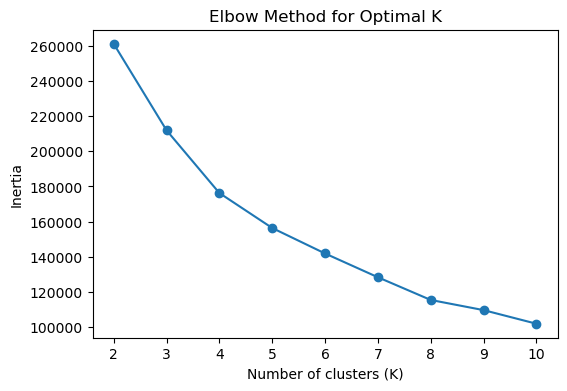

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

### Selection of Optimal Number of Clusters

Based on the elbow method, the optimal number of clusters was determined to be **K = 4**.  
A sharp decrease in inertia is observed up to K = 4, after which the rate of improvement slows, indicating diminishing returns for additional clusters.

## K-Means Clustering (K = 4)
K-Means clustering is applied to segment COVID-19 death cases into four distinct risk profiles based on demographic, clinical, and vaccination-related features.

In [18]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster_scaled)

df_clustered = X_cluster.copy()
df_clustered["cluster"] = cluster_labels

df_clustered["cluster"].value_counts()

cluster
1    19480
2     8709
3     5362
0     3780
Name: count, dtype: int64

### Cluster Distribution

The K-Means algorithm segmented the dataset into four clusters with varying sizes. 
Smaller clusters indicate more distinct risk profiles, while larger clusters represent more common population characteristics.

## Cluster Profiling

To interpret each cluster, the mean values of numerical features are computed to identify distinguishing characteristics across clusters.

In [19]:
cluster_profile = df_clustered.groupby("cluster").mean()
cluster_profile

age      male  malaysian    comorb  gap_positive_to_death  days_last_dose_to_death  \
cluster                                                                                             
0        49.052910  0.592328   0.000000  0.427249               3.648413                 2.651058   
1        63.549230  0.557854   0.999949  0.809959               6.968994                 0.129825   
2        68.262028  0.609714   0.991618  0.893444               5.560570               149.059708   
3        60.220813  0.573294   0.966617  0.789817               7.011749                29.602387   

         vax_status_Fully vaccinated (2 doses)  vax_status_Partial (1 dose)  vax_status_Unvaccinated  
cluster                                                                                               
0                                     0.032275                     0.060582                 0.898148  
1                                     0.000000                     0.000000                 0.978542  
2                                     0.873924                     0.000919                 0.000000  
3                                     0.000000                     1.000000                 0.000000

## Cluster Interpretation

The clustering analysis identified four distinct patient risk profiles:

**Cluster 0 (Low Comorbidity, Unvaccinated):**
Younger individuals with fewer comorbidities but predominantly unvaccinated, exhibiting rapid disease progression.

**Cluster 1 (High-Risk Unvaccinated Elderly):**
Older patients with multiple comorbidities and minimal vaccination coverage, representing the highest mortality-risk group.

**Cluster 2 (Fully Vaccinated Elderly):**
Elderly individuals with comorbidities who were fully vaccinated, indicating reduced severity but vulnerability due to waning immunity.

**Cluster 3 (Partially Vaccinated High-Risk):**
Patients with significant comorbidities who received only partial vaccination, highlighting insufficient protection.

## Association Rule Mining (ARM)

Association Rule Mining is applied to identify frequent and interpretable combinations 
of demographic, clinical, and vaccination-related attributes that commonly co-occur 
among COVID-19 death cases.

Unlike classification and clustering, ARM focuses on generating explainable and 
human-readable patterns in the form of IF–THEN rules. These rules help reveal 
meaningful attribute relationships such as age group, comorbidity status, vaccination 
status, and brought-in-dead (BID) outcomes.

The discovered rules are intended to support public health analysis by highlighting 
frequent risk attribute combinations within COVID-19 death records.

In [20]:
# Core libraries
import pandas as pd
import numpy as np

# Association Rule Mining libraries
from mlxtend.frequent_patterns import apriori, association_rules

# Display settings
pd.set_option("display.max_colwidth", None)

## Attribute Selection and Discretisation

Association Rule Mining requires categorical or binary attributes. 
Therefore, only selected attributes that are meaningful, interpretable, 
and suitable for rule mining are included.

Continuous and high-cardinality attributes are discretised to reduce noise 
and improve the interpretability of the generated rules. The selected 
attributes focus on demographic characteristics, health conditions, 
vaccination status, and clinical outcomes.

In [21]:
# Select only relevant columns for ARM
arm_df = df[[
    'age',
    'comorb',
    'bid',
    'male',
    'malaysian',
    'date_dose1',
    'date_dose2',
    'date_dose3'
]].copy()

arm_df.head()

age  comorb  bid  male  malaysian date_dose1 date_dose2 date_dose3
0   34       1    0     1          1        NaN        NaN        NaN
1   60       1    0     1          1        NaN        NaN        NaN
2   58       1    0     1          1        NaN        NaN        NaN
3   50       1    0     1          1        NaN        NaN        NaN
4   80       1    1     0          1        NaN        NaN        NaN

## Feature Engineering for Association Rule Mining

To improve rule interpretability, continuous and temporal attributes are 
transformed into categorical variables.

Age is discretised into clinically meaningful age groups, and vaccination 
status is derived from vaccination dose information. These transformations 
allow each record to be represented as a transaction consisting of 
interpretable categorical items, which is required for effective 
association rule mining.

In [22]:
# Discretise age into clinically meaningful groups
arm_df['age_group'] = pd.cut(
    arm_df['age'],
    bins=[0, 39, 59, 120],
    labels=['Age<40', 'Age40-59', 'Age>=60']
)

arm_df[['age', 'age_group']].head()

age age_group
0   34    Age<40
1   60   Age>=60
2   58  Age40-59
3   50  Age40-59
4   80   Age>=60

In [23]:
# Derive vaccination status based on number of doses received
arm_df['vaccination_status'] = np.select(
    [
        arm_df['date_dose3'].notna(),
        arm_df['date_dose2'].notna(),
        arm_df['date_dose1'].notna()
    ],
    [
        'Fully_Vaccinated',
        'Partially_Vaccinated',
        'Partially_Vaccinated'
    ],
    default='Unvaccinated'
)

arm_df[['date_dose1', 'date_dose2', 'date_dose3', 'vaccination_status']].head()

date_dose1 date_dose2 date_dose3 vaccination_status
0        NaN        NaN        NaN       Unvaccinated
1        NaN        NaN        NaN       Unvaccinated
2        NaN        NaN        NaN       Unvaccinated
3        NaN        NaN        NaN       Unvaccinated
4        NaN        NaN        NaN       Unvaccinated

## Transaction Representation for ARM

Each COVID-19 death record is transformed into a transaction consisting 
of categorical items. Binary and categorical attributes are converted into 
one-hot encoded format, where each item represents the presence of a 
specific attribute-value pair.

This transaction-based representation is required for applying the 
Apriori algorithm to discover frequent itemsets and association rules.

In [24]:
# Select final attributes for ARM
arm_features = arm_df[
    [
        'age_group',
        'comorb',
        'bid',
        'male',
        'malaysian',
        'vaccination_status'
    ]
].copy()

arm_features.head()

age_group  comorb  bid  male  malaysian vaccination_status
0    Age<40       1    0     1          1       Unvaccinated
1   Age>=60       1    0     1          1       Unvaccinated
2  Age40-59       1    0     1          1       Unvaccinated
3  Age40-59       1    0     1          1       Unvaccinated
4   Age>=60       1    1     0          1       Unvaccinated

In [25]:
# Convert binary variables to categorical labels
binary_map = {
    'comorb': {1: 'Comorbidity_Yes', 0: 'Comorbidity_No'},
    'bid': {1: 'BID_Yes', 0: 'BID_No'},
    'male': {1: 'Male', 0: 'Female'},
    'malaysian': {1: 'Malaysian', 0: 'Non_Malaysian'}
}

for col, mapping in binary_map.items():
    arm_features[col] = arm_features[col].map(mapping)

arm_features.head()

age_group           comorb      bid    male  malaysian vaccination_status
0    Age<40  Comorbidity_Yes   BID_No    Male  Malaysian       Unvaccinated
1   Age>=60  Comorbidity_Yes   BID_No    Male  Malaysian       Unvaccinated
2  Age40-59  Comorbidity_Yes   BID_No    Male  Malaysian       Unvaccinated
3  Age40-59  Comorbidity_Yes   BID_No    Male  Malaysian       Unvaccinated
4   Age>=60  Comorbidity_Yes  BID_Yes  Female  Malaysian       Unvaccinated

In [26]:
arm_transactions = pd.get_dummies(arm_features)
arm_transactions.head()

age_group_Age<40  age_group_Age40-59  age_group_Age>=60  comorb_Comorbidity_No  comorb_Comorbidity_Yes  bid_BID_No  \
0              True               False              False                  False                    True        True   
1             False               False               True                  False                    True        True   
2             False                True              False                  False                    True        True   
3             False                True              False                  False                    True        True   
4             False               False               True                  False                    True       False   

   bid_BID_Yes  male_Female  male_Male  malaysian_Malaysian  malaysian_Non_Malaysian  \
0        False        False       True                 True                    False   
1        False        False       True                 True                    False   
2        False        False       True                 True                    False   
3        False        False       True                 True                    False   
4         True         True      False                 True                    False   

   vaccination_status_Fully_Vaccinated  vaccination_status_Partially_Vaccinated  vaccination_status_Unvaccinated  
0                                False                                    False                             True  
1                                False                                    False                             True  
2                                False                                    False                             True  
3                                False                                    False                             True  
4                                False                                    False                             True

## Frequent Itemset Mining Using Apriori

The Apriori algorithm is applied to identify frequent itemsets within the 
transactional COVID-19 death records. Frequent itemsets represent 
combinations of attribute-value pairs that appear together frequently 
across the dataset.

A minimum support threshold is used to filter out infrequent and noisy 
itemsets, ensuring that only meaningful and representative patterns are 
retained for further rule generation.

In [27]:
# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(
    arm_transactions,
    min_support=0.05,
    use_colnames=True
)

# Sort itemsets by support
frequent_itemsets = frequent_itemsets.sort_values(
    by='support',
    ascending=False
)

frequent_itemsets.head(10)

support                                                   itemsets
9    0.891966                                      (malaysian_Malaysian)
4    0.787790                                   (comorb_Comorbidity_Yes)
5    0.787496                                               (bid_BID_No)
49   0.737993              (comorb_Comorbidity_Yes, malaysian_Malaysian)
54   0.735046                          (bid_BID_No, malaysian_Malaysian)
45   0.652594                       (comorb_Comorbidity_Yes, bid_BID_No)
140  0.626236  (comorb_Comorbidity_Yes, bid_BID_No, malaysian_Malaysian)
12   0.601564                          (vaccination_status_Unvaccinated)
2    0.600680                                        (age_group_Age>=60)
34   0.579143                   (age_group_Age>=60, malaysian_Malaysian)

## Association Rule Generation

After identifying frequent itemsets, association rules are generated to 
capture relationships between combinations of attributes. Each rule is 
represented in the form:

IF (antecedent) → THEN (consequent)

To ensure that only meaningful and reliable rules are retained, thresholds 
on confidence and lift are applied. Confidence measures the reliability of 
a rule, while lift measures the strength of the association beyond random 
co-occurrence.

In [28]:
# Generate association rules from frequent itemsets
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)

# Sort rules by lift in descending order
rules = rules.sort_values(by='lift', ascending=False)

rules.head(10)

antecedents  \
471                                                                (malaysian_Non_Malaysian)   
615                                            (age_group_Age40-59, malaysian_Non_Malaysian)   
614                                                     (male_Male, malaysian_Non_Malaysian)   
536                       (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female)   
533    (bid_BID_No, age_group_Age>=60, vaccination_status_Partially_Vaccinated, male_Female)   
531  (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female, malaysian_Malaysian)   
537                (age_group_Age>=60, vaccination_status_Partially_Vaccinated, male_Female)   
548                                                                       (age_group_Age<40)   
583                                                     (comorb_Comorbidity_No, male_Female)   
549                                              (age_group_Age40-59, comorb_Comorbidity_No)   

                                                          consequents  antecedent support  consequent support  \
471                                 (vaccination_status_Unvaccinated)            0.108034            0.601564   
615                                 (vaccination_status_Unvaccinated)            0.062763            0.601564   
614                                 (vaccination_status_Unvaccinated)            0.063968            0.601564   
536  (comorb_Comorbidity_Yes, age_group_Age>=60, malaysian_Malaysian)            0.118802            0.496477   
533                     (comorb_Comorbidity_Yes, malaysian_Malaysian)            0.080201            0.737993   
531                       (comorb_Comorbidity_Yes, age_group_Age>=60)            0.116204            0.509818   
537         (comorb_Comorbidity_Yes, bid_BID_No, malaysian_Malaysian)            0.094854            0.626236   
548                                 (vaccination_status_Unvaccinated)            0.092792            0.601564   
583                                 (vaccination_status_Unvaccinated)            0.083255            0.601564   
549                                 (vaccination_status_Unvaccinated)            0.091452            0.601564   

      support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
471  0.090970    0.842053  1.399772               1.0  0.025981    2.522592       0.320189  0.147051   0.603582   
615  0.052476    0.836108  1.389889               1.0  0.014721    2.431080       0.299303  0.085767   0.588660   
614  0.052718    0.824121  1.369962               1.0  0.014237    2.265391       0.288508  0.086025   0.558575   
536  0.071683    0.603382  1.215326               1.0  0.012701    1.269541       0.201062  0.131868   0.212314   
533  0.071683    0.893788  1.211106               1.0  0.012495    2.466825       0.189508  0.096024   0.594621   
531  0.071683    0.616874  1.209990               1.0  0.012440    1.279429       0.196365  0.129313   0.218401   
537  0.071683    0.755719  1.206764               1.0  0.012282    1.530058       0.189293  0.110382   0.346430   
548  0.067210    0.724307  1.204039               1.0  0.011389    1.445216       0.186795  0.107167   0.308062   
583  0.060298    0.724260  1.203961               1.0  0.010215    1.444968       0.184793  0.096551   0.307943   
549  0.066031    0.722027  1.200249               1.0  0.011017    1.433361       0.183633  0.105315   0.302339   

     kulczynski  
471    0.496638  
615    0.461670  
614    0.455877  
536    0.373883  
533    0.495460  
531    0.378740  
537    0.435093  
548    0.418016  
583    0.412248  
549    0.415896

## Rule Filtering and Selection

Not all generated association rules are equally meaningful. 
To ensure interpretability and usefulness, rules are filtered based on:

- Confidence ≥ 0.6 to ensure reliability
- Lift > 1.2 to retain only non-random associations
- Antecedents with at least two items to avoid trivial rules

The final selected rules focus on clinically and demographically 
meaningful combinations that can be interpreted in a public health context.

In [29]:
# Filter rules with strong association strength
filtered_rules = rules[
    (rules['lift'] > 1.2) &
    (rules['confidence'] >= 0.6) &
    (rules['antecedents'].apply(lambda x: len(x) >= 2))
]

# Sort by lift
filtered_rules = filtered_rules.sort_values(by='lift', ascending=False)

filtered_rules.head(10)

antecedents  \
615                                            (age_group_Age40-59, malaysian_Non_Malaysian)   
614                                                     (male_Male, malaysian_Non_Malaysian)   
536                       (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female)   
533    (bid_BID_No, age_group_Age>=60, vaccination_status_Partially_Vaccinated, male_Female)   
531  (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female, malaysian_Malaysian)   
537                (age_group_Age>=60, vaccination_status_Partially_Vaccinated, male_Female)   
583                                                     (comorb_Comorbidity_No, male_Female)   
549                                              (age_group_Age40-59, comorb_Comorbidity_No)   

                                                          consequents  antecedent support  consequent support  \
615                                 (vaccination_status_Unvaccinated)            0.062763            0.601564   
614                                 (vaccination_status_Unvaccinated)            0.063968            0.601564   
536  (comorb_Comorbidity_Yes, age_group_Age>=60, malaysian_Malaysian)            0.118802            0.496477   
533                     (comorb_Comorbidity_Yes, malaysian_Malaysian)            0.080201            0.737993   
531                       (comorb_Comorbidity_Yes, age_group_Age>=60)            0.116204            0.509818   
537         (comorb_Comorbidity_Yes, bid_BID_No, malaysian_Malaysian)            0.094854            0.626236   
583                                 (vaccination_status_Unvaccinated)            0.083255            0.601564   
549                                 (vaccination_status_Unvaccinated)            0.091452            0.601564   

      support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
615  0.052476    0.836108  1.389889               1.0  0.014721    2.431080       0.299303  0.085767   0.588660   
614  0.052718    0.824121  1.369962               1.0  0.014237    2.265391       0.288508  0.086025   0.558575   
536  0.071683    0.603382  1.215326               1.0  0.012701    1.269541       0.201062  0.131868   0.212314   
533  0.071683    0.893788  1.211106               1.0  0.012495    2.466825       0.189508  0.096024   0.594621   
531  0.071683    0.616874  1.209990               1.0  0.012440    1.279429       0.196365  0.129313   0.218401   
537  0.071683    0.755719  1.206764               1.0  0.012282    1.530058       0.189293  0.110382   0.346430   
583  0.060298    0.724260  1.203961               1.0  0.010215    1.444968       0.184793  0.096551   0.307943   
549  0.066031    0.722027  1.200249               1.0  0.011017    1.433361       0.183633  0.105315   0.302339   

     kulczynski  
615    0.461670  
614    0.455877  
536    0.373883  
533    0.495460  
531    0.378740  
537    0.435093  
583    0.412248  
549    0.415896

## Interpretation of Association Rules

The filtered association rules reveal meaningful co-occurrence patterns 
among demographic, clinical, and vaccination-related attributes within 
COVID-19 death cases.

Each rule is interpreted as an observed association rather than a causal 
relationship. The interpretations focus on understanding frequent 
attribute combinations that may indicate vulnerability profiles and 
support public health analysis.

In [30]:
# Create a human-readable interpretation for each rule
def interpret_rule(row):
    antecedent = ", ".join(list(row['antecedents']))
    consequent = ", ".join(list(row['consequents']))
    
    return (
        f"Among COVID-19 death cases, individuals with ({antecedent}) "
        f"were {row['lift']:.2f} times more likely to also have "
        f"({consequent}) compared to the overall population."
    )

filtered_rules['interpretation'] = filtered_rules.apply(interpret_rule, axis=1)

filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'interpretation']].head(5)

antecedents  \
615                                            (age_group_Age40-59, malaysian_Non_Malaysian)   
614                                                     (male_Male, malaysian_Non_Malaysian)   
536                       (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female)   
533    (bid_BID_No, age_group_Age>=60, vaccination_status_Partially_Vaccinated, male_Female)   
531  (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female, malaysian_Malaysian)   

                                                          consequents   support  confidence      lift  \
615                                 (vaccination_status_Unvaccinated)  0.052476    0.836108  1.389889   
614                                 (vaccination_status_Unvaccinated)  0.052718    0.824121  1.369962   
536  (comorb_Comorbidity_Yes, age_group_Age>=60, malaysian_Malaysian)  0.071683    0.603382  1.215326   
533                     (comorb_Comorbidity_Yes, malaysian_Malaysian)  0.071683    0.893788  1.211106   
531                       (comorb_Comorbidity_Yes, age_group_Age>=60)  0.071683    0.616874  1.209990   

                                                                                                                                                                                                                                                    interpretation  
615                                                      Among COVID-19 death cases, individuals with (age_group_Age40-59, malaysian_Non_Malaysian) were 1.39 times more likely to also have (vaccination_status_Unvaccinated) compared to the overall population.  
614                                                               Among COVID-19 death cases, individuals with (male_Male, malaysian_Non_Malaysian) were 1.37 times more likely to also have (vaccination_status_Unvaccinated) compared to the overall population.  
536  Among COVID-19 death cases, individuals with (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female) were 1.22 times more likely to also have (comorb_Comorbidity_Yes, age_group_Age>=60, malaysian_Malaysian) compared to the overall population.  
533  Among COVID-19 death cases, individuals with (bid_BID_No, age_group_Age>=60, vaccination_status_Partially_Vaccinated, male_Female) were 1.21 times more likely to also have (comorb_Comorbidity_Yes, malaysian_Malaysian) compared to the overall population.  
531  Among COVID-19 death cases, individuals with (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female, malaysian_Malaysian) were 1.21 times more likely to also have (comorb_Comorbidity_Yes, age_group_Age>=60) compared to the overall population.

## Summary of Key Association Rules

A final subset of high-quality association rules is selected based on 
confidence, lift, and interpretability. These rules represent the most 
meaningful co-occurrence patterns observed in COVID-19 death records.

The summarized rules are used for result discussion, application 
visualization, and decision-support insights.

In [31]:
# Create a clean, final ARM summary table
arm_summary = filtered_rules[
    [
        'antecedents',
        'consequents',
        'support',
        'confidence',
        'lift',
        'interpretation'
    ]
].reset_index(drop=True)

arm_summary

antecedents  \
0                                            (age_group_Age40-59, malaysian_Non_Malaysian)   
1                                                     (male_Male, malaysian_Non_Malaysian)   
2                       (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female)   
3    (bid_BID_No, age_group_Age>=60, vaccination_status_Partially_Vaccinated, male_Female)   
4  (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female, malaysian_Malaysian)   
5                (age_group_Age>=60, vaccination_status_Partially_Vaccinated, male_Female)   
6                                                     (comorb_Comorbidity_No, male_Female)   
7                                              (age_group_Age40-59, comorb_Comorbidity_No)   

                                                        consequents   support  confidence      lift  \
0                                 (vaccination_status_Unvaccinated)  0.052476    0.836108  1.389889   
1                                 (vaccination_status_Unvaccinated)  0.052718    0.824121  1.369962   
2  (comorb_Comorbidity_Yes, age_group_Age>=60, malaysian_Malaysian)  0.071683    0.603382  1.215326   
3                     (comorb_Comorbidity_Yes, malaysian_Malaysian)  0.071683    0.893788  1.211106   
4                       (comorb_Comorbidity_Yes, age_group_Age>=60)  0.071683    0.616874  1.209990   
5         (comorb_Comorbidity_Yes, bid_BID_No, malaysian_Malaysian)  0.071683    0.755719  1.206764   
6                                 (vaccination_status_Unvaccinated)  0.060298    0.724260  1.203961   
7                                 (vaccination_status_Unvaccinated)  0.066031    0.722027  1.200249   

                                                                                                                                                                                                                                                  interpretation  
0                                                      Among COVID-19 death cases, individuals with (age_group_Age40-59, malaysian_Non_Malaysian) were 1.39 times more likely to also have (vaccination_status_Unvaccinated) compared to the overall population.  
1                                                               Among COVID-19 death cases, individuals with (male_Male, malaysian_Non_Malaysian) were 1.37 times more likely to also have (vaccination_status_Unvaccinated) compared to the overall population.  
2  Among COVID-19 death cases, individuals with (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female) were 1.22 times more likely to also have (comorb_Comorbidity_Yes, age_group_Age>=60, malaysian_Malaysian) compared to the overall population.  
3  Among COVID-19 death cases, individuals with (bid_BID_No, age_group_Age>=60, vaccination_status_Partially_Vaccinated, male_Female) were 1.21 times more likely to also have (comorb_Comorbidity_Yes, malaysian_Malaysian) compared to the overall population.  
4  Among COVID-19 death cases, individuals with (bid_BID_No, vaccination_status_Partially_Vaccinated, male_Female, malaysian_Malaysian) were 1.21 times more likely to also have (comorb_Comorbidity_Yes, age_group_Age>=60) compared to the overall population.  
5  Among COVID-19 death cases, individuals with (age_group_Age>=60, vaccination_status_Partially_Vaccinated, male_Female) were 1.21 times more likely to also have (comorb_Comorbidity_Yes, bid_BID_No, malaysian_Malaysian) compared to the overall population.  
6                                                               Among COVID-19 death cases, individuals with (comorb_Comorbidity_No, male_Female) were 1.20 times more likely to also have (vaccination_status_Unvaccinated) compared to the overall population.  
7                                                        Among COVID-19 death cases, individuals with (age_group_Age40-59, comorb_Comorbidity_No) were 1.20 times more likely to also have (vaccination_status_Unvaccinated) compared to

## Export Data Mining Outputs for Dashboard Deployment

This section exports the final data mining outputs generated in this 
notebook for use in the interactive dashboard application. The exported 
artifacts include:

- Trained classification model for BID risk prediction
- Summarized association rules with interpretations
- Cluster profiles derived from unsupervised learning

These outputs enable the dashboard to present data mining insights without 
retraining models, ensuring consistency and efficiency.

In [33]:
import os
import pickle

# Create output directory
os.makedirs("outputs", exist_ok=True)

# Export Logistic Regression model
with open("outputs/log_reg_model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

# Export ARM rules summary
arm_summary.to_csv("outputs/arm_rules.csv", index=False)

# Export cluster profiles (FIXED variable name)
cluster_profile.to_csv("outputs/cluster_profiles.csv", index=False)

print("✅ All data mining outputs exported successfully!")

✅ All data mining outputs exported successfully!
